# 0010 Final Project: The Best Neighborhood in Pittsburgh

## Team All Across the World

Keyon Hedayati (keh204@pitt.edu)

Minhal Khan (mik172@pitt.edu)

Zhen Wu (zhw87@pitt.edu)

## Metrics
To determine the best neighborhood in Pittsburgh, we decided to base our metrics on factors that make for a comfortable life in a neighborhood, namely community closeness and cleanliness, opportunities for recreation, and access to public art.

## Cleanliness and Community Closeness - Keyon

In [11]:
# Import imports

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas
import plotly.express as px
from shapely.geometry import Point, Polygon

**INTRO**

The datasets I will be using will be of the Pittsburgh local food gardens, and Smart Trash can locations. The goal of my datasets will be to score and determine a level of cleanliness and signs of a close knit community. The latter of which was determined as number 5 on Forbes top 10 things to look for in a neighborhood. I will be combining these two data sets to come up with an ultimate score (https://www.forbes.com/sites/learnvest/2017/08/02/10-things-you-should-look-for-when-choosing-a-new-neighborhood/?sh=65171b6b5fbc).

Additionally, according to research Smart Trash cans are great for the city and neighborhood. They cut on municiple costs, by only sending garbage trucks when they are needed. They also make sure there are no 'overflowing' trash cans. Trash cans that overflow cause more litter than just the overflow. When people see that a can is overflowing, they tend to litter more. That is why I will convert the locations of trash cans to neighborhoods, and develop a metric that looks at trash cans per population density. More information about the benefits of smart trash cans are found at https://www.smartcitiesdive.com/news/pittsburghs-smart-garbage-cans-help-streamline-public-works/559156/#:~:text=The%20smart%20cans%20have%20sensors,most%20efficient%20routes%20for%20collection

In [12]:
# import the data sources we will be playing with
grow = pd.read_csv('https://data.wprdc.org/dataset/0d8c9708-3f01-48c4-adff-04d29825c9a2/resource/dbdfcb3e-8fa5-4468-9b05-f69562798f7a/download/growpghgardens201712.csv')
trash = pd.read_csv('https://data.wprdc.org/datastore/dump/75b83ac9-8069-4cf1-bcc3-b9e6b04487d9')
grow = grow.drop(['url', 'country', 'state', 'grower_id'], axis = 1) # clean up data by dropping some columns
grow = grow[grow.city == 'Pittsburgh'] # limit to pittsburgh city




I will be working on the food garden data first. The two main things will be to get pittsburgh divided into neighborhoods since the food garden data doesn't have that information. So I will need to combine a neighborhood map with the food garden locations.

In [13]:
# get the neighborhood map
neighborhoods = geopandas.read_file("Neighborhoods/Neighborhoods_.shp") # read in the shapefile
crs = {'init': 'EPSG:4326'} #this is a coordinate reference system, but not really sure how it works
# need to add geometry so we can drop points on the map, and potentially add a column later
geometry = [Point(xy) for xy in zip(grow["longitude"], grow['latitude'])]

#geo_df = geopandas.GeoDataFrame(grow, crs = crs, geometry=geometry)
geo_df = geopandas.GeoDataFrame(grow, geometry=geometry) # i don't think we need crs anymore, should be built in




In [14]:
# attempt to merge the neighborhood data into the trash can data and map on plotly


# convert plain df to geopandas df

geo_df_geopanda = geopandas.GeoDataFrame(geo_df, geometry=geopandas.points_from_xy(geo_df.longitude, geo_df.latitude))
geo_df_geopanda = geo_df_geopanda.set_crs("EPSG:4326")   # don't think I need this anymore
geo_df = geo_df.set_crs("EPSG:4326")

point_in_neigh = geopandas.sjoin(geo_df, neighborhoods, how='left', op='within')
                
# going to try and make map of this data now
# plotly version of the data, so can zoom and get neighborhood maps, etc
px.set_mapbox_access_token('pk.eyJ1Ijoia2V5b25jYWwiLCJhIjoiY2tuYWM4b25rMWc5djJvbGdyYmFuN3c4MiJ9.CxmqbsOMXQHFuVwsUEFoTg')
fig = px.scatter_mapbox(point_in_neigh, lat="latitude", lon="longitude", zoom=11, hover_name='hood')                  
fig.show()





Now that the food garden map is complete, I can start on the smart trash can information.

In [15]:
# time to work on trash can data. 
# gonna try convert it to geo pandas, and maybe helps get the neighborhood name
trash_df = trash # copy just in case 

trash_geo = geopandas.GeoDataFrame(trash_df, geometry=geopandas.points_from_xy(trash_df.x, trash_df.y))
trash_geo.set_crs("EPSG:4326")

px.set_mapbox_access_token('pk.eyJ1Ijoia2V5b25jYWwiLCJhIjoiY2tuYWM4b25rMWc5djJvbGdyYmFuN3c4MiJ9.CxmqbsOMXQHFuVwsUEFoTg')
fig = px.scatter_mapbox(trash_geo, lat="y", lon="x", zoom=11, hover_name="neighborhood")                  
fig.show()

# this cell works to get the trash cans on the map, and show the neighborhood on hover

Now for the ultimate goal. Combine the two data sets and come up with a metric that describes my goal. Each neighborhood will end up with a score that is determined by how many smart trash cans they have, and if they have a local food garden.

In [16]:
# want to merge the two data sets so can do metric of trash_grow / 100 people
grow_neigh = point_in_neigh
trash_df = trash_geo

trash_df=trash_df.rename(columns={'neighborhood':'hood'})   # rename columns so they match for the aggregate

# want to know how many trash and food are in each neighborhood. So going to just do a count of neighborhoods in eac
grow_neigh_group= grow_neigh.dissolve(by='hood', aggfunc='count')
trash_df_group = trash_df.dissolve(by='hood', aggfunc='count')

# now need to merge the data
merged_df = trash_df_group.merge(grow_neigh_group, on='hood', how='left')   # trash has more entries so merge on left
merged_df = merged_df[['container_id', 'page_numbe']]   # since just a count, we only need these two columns (maybe add geometry later)
merged_df = merged_df.rename(columns={'container_id':'smart_trash', 'page_numbe': 'food_garden'})  # rename columns to make clear
merged_df['food_garden'] = merged_df['food_garden'].fillna(0)   # get rid of the NaN by replacing with 0


merged_df



,smart_trash,food_garden
hood,,
Allegheny Center,9,0.0
Allegheny West,15,0.0
Allentown,12,0.0
Arlington,3,0.0
Banksville,2,0.0
...,...,...
Upper Lawrenceville,16,0.0
West End,9,1.0
West Oakland,9,3.0


In [17]:
# now that we just have the breakdown of smart_trash and food_garden by neighborhood lets get population
#pop_df = pd.read_csv('https://data.wprdc.org/dataset/3cb2b9c2-66e2-4ffa-b0a1-35fb2c6f7230/resource/eb1f8714-e0eb-4614-acfe-dfe0ebab942f/download/school-enrollment-by-detailed-level-of-school-for-the-population-3-years-and-over.csv')
pop_df = pd.read_csv('https://data.wprdc.org/dataset/40188e1c-6d2e-4f20-9391-607bd3054949/resource/8ac5c768-09ba-43a8-829f-ce4a417d20fb/download/population-density.csv')
pop_df = pop_df[['Neighborhood', 'Land Area (acres)', 'Pop. 2010']]   # only want the population
pop_df = pop_df.rename(columns = {'Neighborhood':'hood', 'Land Area (acres)':'area', 'Pop. 2010':'pop'})  #rename the columns
merged_final = merged_df.merge(pop_df, how='left', on='hood')
merged_final.replace(',','', regex=True, inplace=True)
merged_final['area'] = merged_final['area'].astype(float)
merged_final['pop'] = merged_final['pop'].astype(float)
merged_final['percent_pop'] = merged_final['pop'] / merged_final['pop'].sum()
merged_final

,hood,smart_trash,food_garden,area,pop,percent_pop
0,Allegheny Center,9,0.0,134.4,933.0,0.003156
1,Allegheny West,15,0.0,90.2,462.0,0.001563
2,Allentown,12,0.0,188.8,2500.0,0.008457
3,Arlington,3,0.0,300.8,1869.0,0.006322
4,Banksville,2,0.0,620.2,4144.0,0.014018
...,...,...,...,...,...,...
74,Upper Lawrenceville,16,0.0,259.2,2669.0,0.009028
75,West End,9,1.0,128.0,254.0,0.000859
76,West Oakland,9,3.0,137.6,2604.0,0.008808
77,Westwood,5,0.0,442.9,3066.0,0.010371


In [18]:
# now we can add the column for the metric
merged_final.describe()    # to help guide us for weighting garden more

,smart_trash,food_garden,area,pop,percent_pop
count,79.000000,79.000000,79.000000,79.000000,79.000000
mean,16.025316,0.708861,396.905063,3742.101266,0.012658
std,18.071067,1.099556,309.291995,3290.050384,0.011129
min,1.000000,0.000000,64.000000,11.000000,0.000037
25%,4.000000,0.000000,181.400000,1365.000000,0.004617
50%,9.000000,0.000000,284.800000,2714.000000,0.009181
75%,19.000000,1.000000,532.150000,4742.000000,0.016041
max,78.000000,4.000000,1709.400000,15110.000000,0.051112


,hood,smart_trash,food_garden,area,pop,percent_pop,clean_score
60,South Shore,1,0.0,135.7,19.0,0.000064,0.000047
18,Chateau,4,0.0,245.1,11.0,0.000037,0.000061
67,St. Clair,1,0.0,198.4,209.0,0.000707,0.000356
23,East Carnegie,1,0.0,276.5,570.0,0.001928,0.000697
70,Swisshelm Park,1,0.0,307.2,1361.0,0.004604,0.001499
...,...,...,...,...,...,...,...
9,Bluff,32,1.0,209.3,6600.0,0.022326,0.394670
8,Bloomfield,60,2.0,449.3,8442.0,0.028556,0.444902
25,East Liberty,72,4.0,371.8,5869.0,0.019853,0.491247
17,Central Oakland,44,0.0,179.8,6086.0,0.020587,0.503793


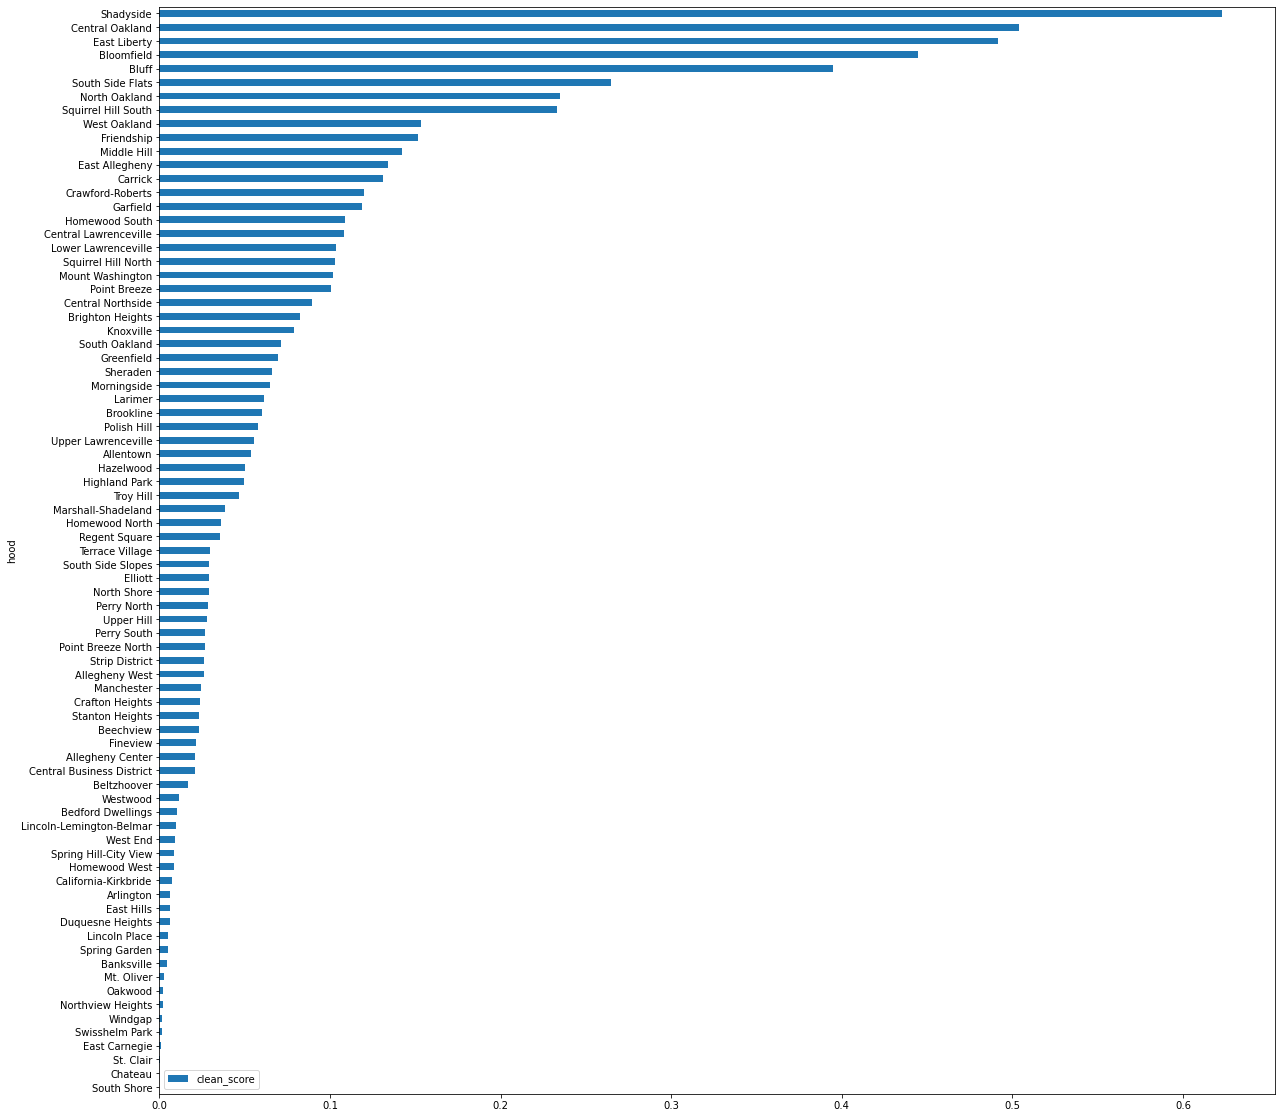

In [19]:
# we will make every food garden worth 5 points, and every trash can worth 1 point
# then we will figure out how many points per area size and weight by populations percent.
# Hopefully giving us our best areas in pitt as judged by level of community and cleanliness
merged_final['clean_score'] = ((merged_final['smart_trash'] + (merged_final['food_garden'] * 5)) / (merged_final['area']/100)) * merged_final['percent_pop']

# lets see how the data looks on a bar graph


merged_final_sort = merged_final.sort_values(by=['clean_score'], ascending=True)

graph = merged_final_sort.plot.barh(x='hood', y='clean_score', figsize=(20, 20))
merged_final_sort

According to my data **Shadyside** is both a clean neighborhood, with lots of local love. In other words, it is a clean, and close-knit community.

***

## Recreation Opportunities in Populated Neighborhoods - Minhal

My metric for determining the best neighborhood in Pittsburgh is the number of recreation facilities per population for each neighborhood. In this context, the term 'recreation facilities' refers to places where people can pursue hobbies and have fun, like pools, gyms, and rec centers. In my view, a good neighborhood is one that has plenty of opportunities to relax and meet new people. The ideal neighborhood should strike a happy medium between a high amount of people and rec facilities.

For my metric, I'll be using the facilities and Pittsburgh population density datasets from the WPRDC, located here:

**Facilities:** https://data.wprdc.org/datastore/dump/fbb50b02-2879-47cd-abea-ae697ec05170

**Population Density 2010:** https://data.wprdc.org/dataset/40188e1c-6d2e-4f20-9391-607bd3054949/resource/8ac5c768-09ba-43a8-829f-ce4a417d20fb/download/population-density.csv

In [20]:
# Imports
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import geopandas as gd
%matplotlib inline

# Reading data
df = pd.read_csv("fac.csv")
pop = pd.read_csv("https://data.wprdc.org/dataset/40188e1c-6d2e-4f20-9391-607bd3054949/resource/8ac5c768-09ba-43a8-829f-ce4a417d20fb/download/population-density.csv")
neighborhoods = gd.read_file("Neighborhoods/Neighborhoods_.shp")

In [21]:
df.head()

,id,parcel_id,inactive,name,rentable,type,primary_user,address_number,street,zip,...,neighborhood,council_district,ward,tract,public_works_division,pli_division,police_zone,fire_zone,latitude,longitude
0,650726265,120-J-300,f,57th Street Park Building,f,Storage,Department of Public Works,NaN,57TH ST,NaN,...,Upper Lawrenceville,7,10.0,42003101100,2.0,10.0,2.0,3-5,40.485658,-79.946446
1,783044037,2-H-284,f,Albert Turk Graham Park Shelter,f,Shelter,Department of Public Works,39.0,VINE ST,NaN,...,Crawford-Roberts,6,3.0,42003030500,3.0,3.0,2.0,2-1,40.440464,-79.984103
2,1997158435,23-R-157,f,Allegheny Northside Senior Center and Hazlett ...,t,Senior,CitiParks,5.0,ALLEGHENY SQ E,15212.0,...,Allegheny Center,1,22.0,42003562700,1.0,22.0,1.0,1-6,40.453091,-80.005339
3,204824684,10-F-198,f,Ammon Recreation Center,f,Pool,CitiParks,2217.0,BEDFORD AVE,15219.0,...,Bedford Dwellings,6,5.0,42003050900,3.0,5.0,2.0,2-5,40.448727,-79.977853
4,472140955,013-K-314,f,Arlington Field Lights Building,f,Utility,CitiParks,0.0,STERLING ST,15210.0,...,South Side Slopes,3,16.0,42003160800,3.0,16.0,3.0,4-22,40.418144,-79.974468


Facilities.csv is a fairly extensive dataset that has all sorts of information on a variety of facilities beyond recreational. Let's use this data to get an idea of the number of rec facilities in each neighborhood. The *type, neighborhood, inactive* columns should serve our purposes for now.

In [22]:
# Refine data. Remove inactive facilities
df = df[(df['inactive'] != 't')].dropna(subset=['inactive']).reset_index(drop=True)

#Create subset
df2 = df[['neighborhood','id']].groupby('neighborhood').count().rename(columns={'id':'facility_num'})

df2.head()

,facility_num
neighborhood,
Allegheny Center,4
Allegheny West,3
Allentown,3
Banksville,5
Bedford Dwellings,6


First, we filter out all facilities that are inactive. We then use .count() to get the total number of facilities for each neighborhood. Finally, we create a subset containing each neighborhood as well as their total facilities.

In [23]:
rec_areas = ['Pool', 'Rec Center', 'Shelter', 'Community', 'Pool/Rec', 'Activity']

#Calculate total number of recreational facilities in each neighborhood
df['num'] = 1
rec = df[['neighborhood','num']].loc[df['type'].isin(rec_areas)].groupby('neighborhood').count().rename(columns={'num':'rec_num'})

rec.head()

,rec_num
neighborhood,
Allegheny Center,2
Allentown,1
Banksville,2
Bedford Dwellings,1
Beltzhoover,2


Let's calculate the number of *recreational* facilities in each neighborhood. We can do this by filtering out rows in our original dataset that have facilities belonging to our filter, rec_areas. Then, we add them up by grouping by neighborhood and using .count(). 

The rec dataframe will come in handy when we work on the metric. For now, though, I'd like to use this data for visualization purposes.

,facility_num,rec_num
neighborhood,,
Squirrel Hill South,29,15
Highland Park,30,12
Perry North,20,9
Brookline,19,7
Mount Washington,7,5


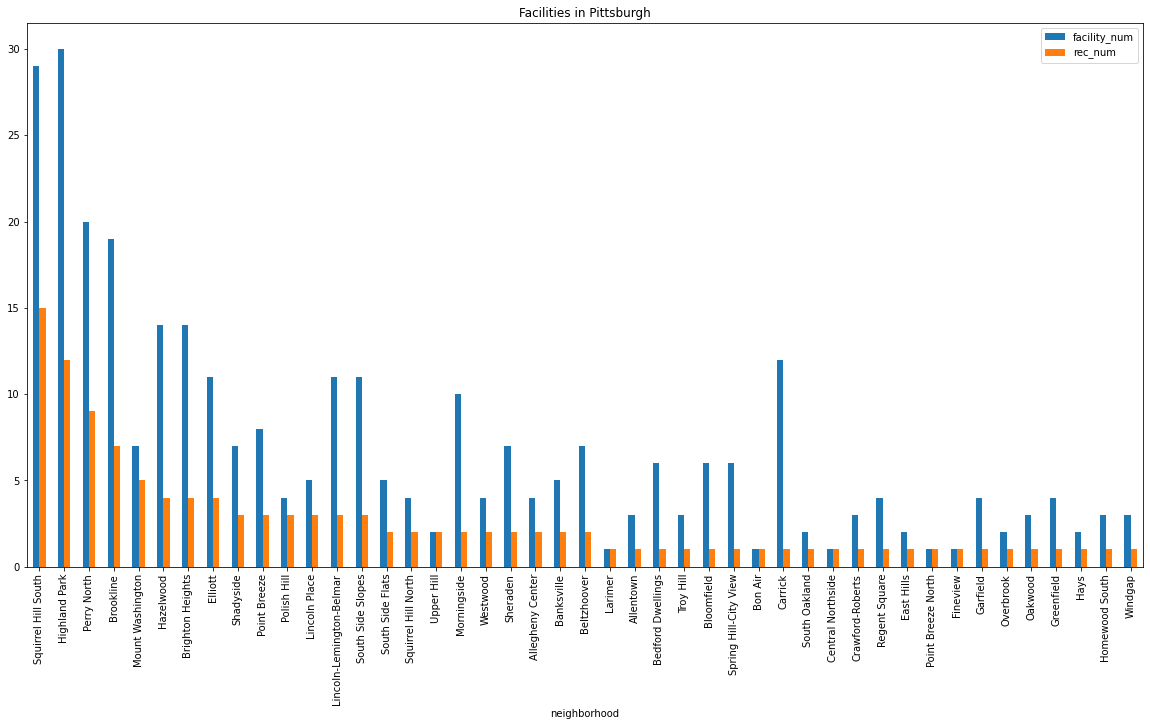

In [24]:
df3 = df2.merge(rec,on='neighborhood').sort_values('rec_num',ascending=False)
df3.plot.bar(figsize=(20,10), title='Facilities in Pittsburgh')

df3.head()

By merging the dataframes containing the total facilities as well as rec facilities on the common column of neighborhood, we can create an entirely new dataframe that helps us put the number of rec facilities in perspective. So far, Squirrel Hill South and Highland Park, among others, have high numbers of recreational facilities. 

<AxesSubplot:>

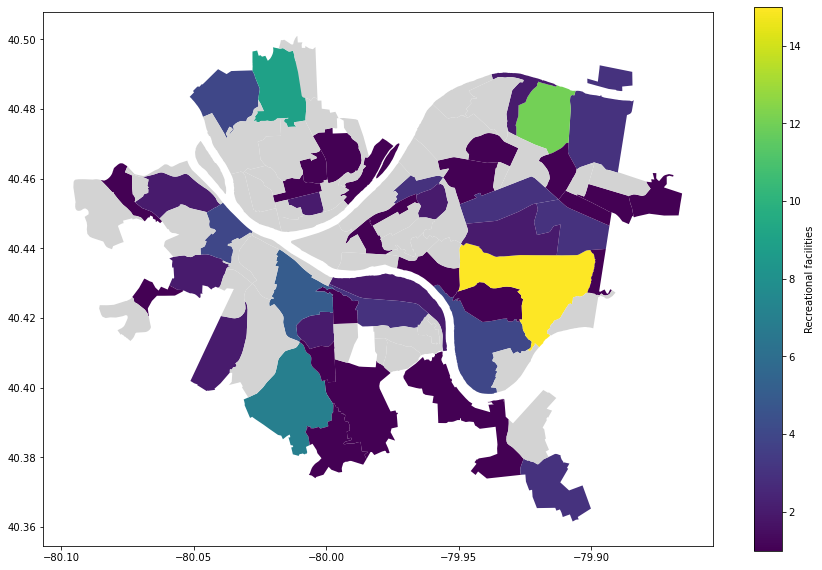

In [25]:
merged_hoods = neighborhoods.merge(rec, how='left', left_on='hood', right_on='neighborhood')

merged_hoods.plot(column='rec_num',
                  legend=True,
                  legend_kwds={'label':'Recreational facilities'},
                  figsize=(15,10),
                  missing_kwds={'color':'lightgrey'})


As an added bonus, here's a choropleth map of the number of rec facilities in each neighborhood. 

### The Metric

The metric being used to rank Pittsburgh's neighborhoods is based on the ratio of number of rec facilities to neighborhood population. 

In [26]:
# Create a subset of Pop density data and merge it with the number of rec facilities
pop = pop[['Pop. 2010','Neighborhood']]
df4 = rec.merge(pop, left_on='neighborhood',right_on='Neighborhood').rename(columns={'Pop. 2010':'pop'})

First, we create a subset of the population density data that contains the latest population data for each neighborhood, then merge it with the number of rec facilities in each neighborhood.

In [27]:
df4.head()

,rec_num,pop,Neighborhood
0,2,933,Allegheny Center
1,1,"2,500",Allentown
2,2,"4,144",Banksville
3,1,"1,202",Bedford Dwellings
4,2,"1,925",Beltzhoover


So far, so good! But the values in the *pop* column are of string type, which will cause problems when we use them for calculations later on. Let's convert these values to a usable type.

In [28]:
# Convert pop and num columns to float for calculation purposes
df4['pop'].replace(',','', regex=True, inplace=True)
df4 = df4.astype({'rec_num':'float','pop':'float'})

,Neighborhood,rec_num,pop,rec_ratio
0,Highland Park,12.0,6395.0,0.001876
1,Squirrel Hill South,15.0,15110.0,0.000993
2,South Side Slopes,3.0,4423.0,0.000678
3,Lincoln-Lemington-Belmar,3.0,4883.0,0.000614
4,Mount Washington,5.0,8799.0,0.000568
5,Point Breeze,3.0,5315.0,0.000564
6,Brighton Heights,4.0,7247.0,0.000552
7,Brookline,7.0,13214.0,0.000530
8,Sheraden,2.0,5299.0,0.000377
9,South Side Flats,2.0,6597.0,0.000303


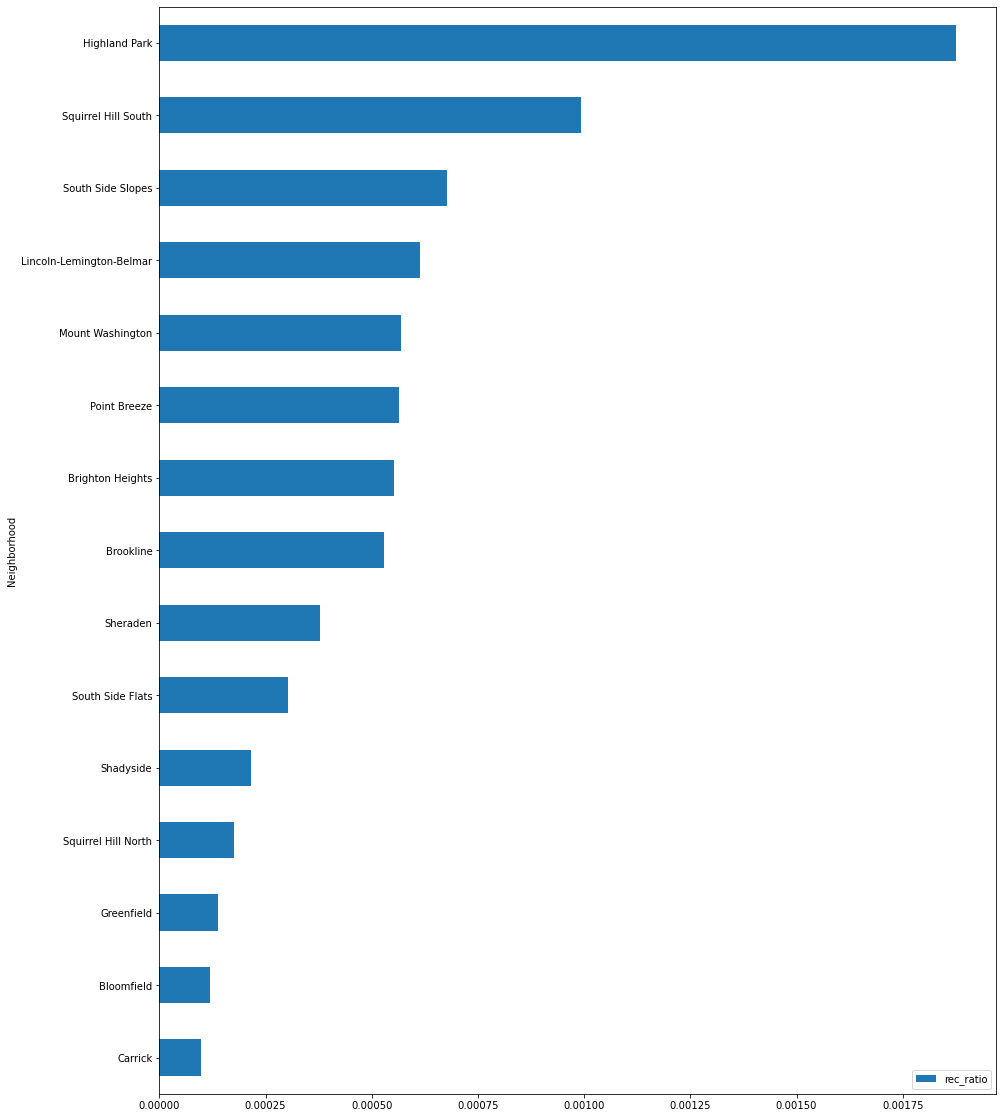

In [29]:
# Create new column with ratios
df4['rec_ratio'] = df4['rec_num']/df4['pop']

# Reorganize the dataframe and filter out neighborhoods with low populations
df4 = df4[['Neighborhood','rec_num','pop','rec_ratio']].sort_values('rec_ratio')
df4 = df4[df4['pop'] > df4['pop'].mean()]

# Plot!
df4.plot.barh(y='rec_ratio', x='Neighborhood', figsize=(15,20))

df4.sort_values('rec_ratio', ascending=False).reset_index(drop=True)

We create a column with rec facility ratios for each neighborhood, then filter out neighborhoods with low population levels (i.e., below the mean). Finally, we plot our data.

It can be seen that **Highland Park** comes out on top, followed by Squirrel Hill South, South Side Slopes, Lincoln-Lemington-Belmar and Mount Washington.

***

## Access to Public Art in Pittsburgh Neighborhoods - Zhen

Public art is a spirit of innovation and a tag of the inner-city culture. According to https://www.smartcitiesdive.com/ex/sustainablecitiescollective/how-tough-neighborhood-building-stronger-future-vivid-public-art/91756/, it makes the neighborhoods more vibrant and improves the social environment. Thus, we suppose that more public art pieces in the neighborhood, the better the neighborhood is.

In [30]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas as gpd

Let's get the public art data from the WPRDC (https://data.wprdc.org/dataset/city-of-pittsburgh-public-art/resource/00d74e83-8a23-486e-841b-286e1332a151?view_id=7c4a2734-ec64-46a0-95ad-39d4fe599ae0).
Below shows a sample of what the data looks like on the WPRDC website.

In [31]:
publicArt = pd.read_csv("public-art.csv")
publicArt.head(5)

,id,name,title,artist_name,art_type,park,image,neighborhood,council_district,ward,tract,public_works_division,pli_division,police_zone,fire_zone,latitude,longitude
0,812728309,1001,Oakwood Road Monument,NaN,NaN,NaN,NaN,Oakwood,2.0,28.0,4.200356e+10,5.0,28.0,6.0,1-19,40.429192,-80.066225
1,188255168,1002,Rooster Waiting For The Streetcar,James Simon,Modern and Contemporary Art,NaN,NaN,Elliott,2.0,20.0,4.200356e+10,5.0,20.0,6.0,1-17,40.442926,-80.039711
2,2032091917,129,Middle East Memorial Plaque,NaN,War Memorials,NaN,NaN,Central Business District,6.0,1.0,4.200302e+10,6.0,1.0,2.0,1-4,40.438092,-79.996852
3,1447629273,143,L'Enfant,Paul Roger-Bloche,Historic Art,NaN,NaN,Carrick,4.0,29.0,4.200329e+10,3.0,29.0,3.0,4-23,40.388748,-79.986497
4,1935017944,148,Veterans Memorial (Brookline),NaN,War Memorials,Brookline Monument,NaN,Brookline,4.0,19.0,4.200319e+10,5.0,19.0,6.0,4-26,40.391721,-80.016981


Let's group the data by neighborhoods and see the number of public art pieces in each of the neighborhood:

In [32]:
length = len(publicArt.groupby("neighborhood"))
publicArt.groupby("neighborhood").count().loc[:,"id"][:length]

neighborhood
Allegheny Center             18
Allegheny West                1
Allentown                     2
Beechview                     8
Beltzhoover                   3
Bloomfield                    1
Brighton Heights              5
Brookline                     2
Carrick                       3
Central Business District    27
Central Lawrenceville         2
Central Oakland               5
Crafton Heights               1
Crawford-Roberts              3
Duquesne Heights              3
East Allegheny                2
East Carnegie                 1
East Hills                    1
East Liberty                  1
Elliott                       3
Esplen                        1
Garfield                      2
Greenfield                    3
Hays                          1
Hazelwood                     4
Highland Park                10
Knoxville                     1
Lincoln-Lemington-Belmar      2
Lower Lawrenceville           5
Manchester                    1
Mount Washington           

Furthermore, let's sort the data in descending order so we can have a better understanding of which neighborhoods have more pieces of public art.

In [33]:
art_sort = publicArt.groupby("neighborhood").count().loc[:,"id"].sort_values(ascending=False)
art_sort[:length]

neighborhood
Central Business District    27
Squirrel Hill South          22
Allegheny Center             18
South Side Flats             10
Highland Park                10
North Shore                   8
Beechview                     8
Shadyside                     6
Brighton Heights              5
Central Oakland               5
Lower Lawrenceville           5
Hazelwood                     4
Spring Hill-City View         4
Greenfield                    3
Point Breeze                  3
Elliott                       3
Duquesne Heights              3
South Side Slopes             3
Crawford-Roberts              3
Carrick                       3
Beltzhoover                   3
Spring Garden                 2
Regent Square                 2
Squirrel Hill North           2
Perry North                   2
Strip District                2
Upper Hill                    2
Mount Washington              2
Lincoln-Lemington-Belmar      2
West End                      2
Allentown                  

Plot the data as a bar graph:

<AxesSubplot:xlabel='neighborhood'>

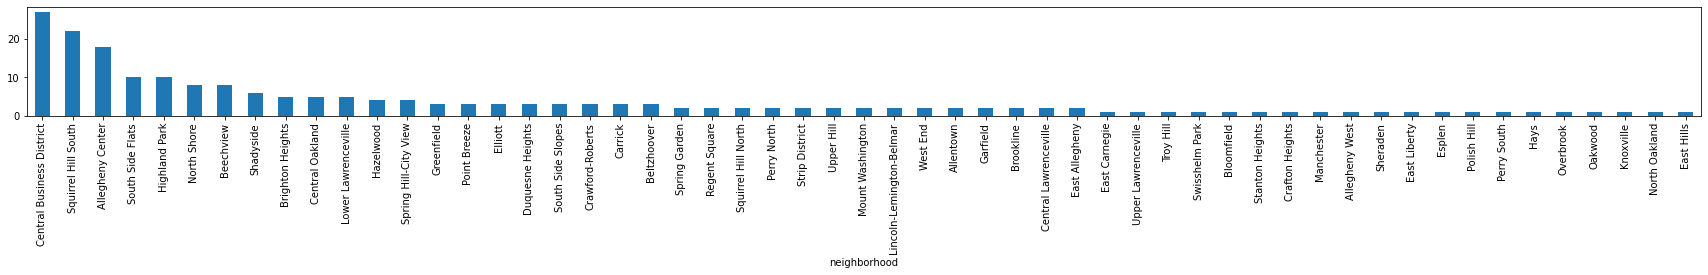

In [34]:
art_sort[:length].plot.bar(figsize = (30, 2))

Now, scale down to figure out how many pieces of public art per 100m^2 for each neighborhood. 

In [35]:
neighborhoods = gpd.read_file("Neighborhoods/Neighborhoods_.shp")
neighborhoods[['hood','area','geometry']]

,hood,area,geometry
0,Central Oakland,7843108.0,"POLYGON ((-79.95304 40.44203, -79.95302 40.442..."
1,North Oakland,13904629.0,"POLYGON ((-79.95455 40.45882, -79.95427 40.458..."
2,West Oakland,5999801.5,"POLYGON ((-79.96230 40.44294, -79.96220 40.442..."
3,Crawford-Roberts,7202139.0,"POLYGON ((-79.98275 40.44641, -79.98273 40.446..."
4,Strip District,16947852.0,"POLYGON ((-79.97494 40.45629, -79.97484 40.456..."
...,...,...,...
85,Ridgemont,10278895.0,"POLYGON ((-80.03431 40.43366, -80.03424 40.433..."
86,West End,5579501.0,"POLYGON ((-80.02869 40.44454, -80.02845 40.444..."
87,California-Kirkbride,6050988.0,"POLYGON ((-80.02039 40.46285, -80.02022 40.462..."
88,Glen Hazel,12713036.0,"POLYGON ((-79.92030 40.41205, -79.92027 40.412..."


In [36]:
# do the merge
area_map = neighborhoods.merge(art_sort, how='left', left_on='hood', right_on='neighborhood')
area_map = area_map.rename(columns={'id':'total pieces of public art'})
# replace NaN in total pieces of public art by 0 
area_map['total pieces of public art'] = area_map['total pieces of public art'].fillna(0)
# replace NaN in area by calculation from its polygon
area_replace = area_map['geometry'].to_crs(epsg=32129)
area_map['area'] = area_map['area'].fillna(pd.to_numeric(area_replace.area))
area_map = area_map[['hood','total pieces of public art','area']]

In [37]:
# calculate number of pieces of public art per 100m^2
area_map['art_percent'] = (area_map['total pieces of public art']/(area_map['area']/10**4))
area_map

,hood,total pieces of public art,area,art_percent
0,Central Oakland,5.0,7.843108e+06,0.006375
1,North Oakland,1.0,1.390463e+07,0.000719
2,West Oakland,0.0,5.999802e+06,0.000000
3,Crawford-Roberts,3.0,7.202139e+06,0.004165
4,Strip District,2.0,1.694785e+07,0.001180
...,...,...,...,...
85,Ridgemont,0.0,1.027890e+07,0.000000
86,West End,2.0,5.579501e+06,0.003585
87,California-Kirkbride,0.0,6.050988e+06,0.000000
88,Glen Hazel,0.0,1.271304e+07,0.000000


In [38]:
area_map.describe()

,total pieces of public art,area,art_percent
count,90.000000,9.000000e+01,90.000000
mean,2.266667,1.601237e+07,0.001655
std,4.362249,1.278851e+07,0.003810
min,0.000000,2.871538e+06,0.000000
25%,0.000000,7.686451e+06,0.000000
50%,1.000000,1.185390e+07,0.000623
75%,2.000000,2.088152e+07,0.001763
max,27.000000,7.447013e+07,0.030818


The bar graph showing total number of pieces of public art per 100m^2 for each neighborhood.

<AxesSubplot:ylabel='hood'>

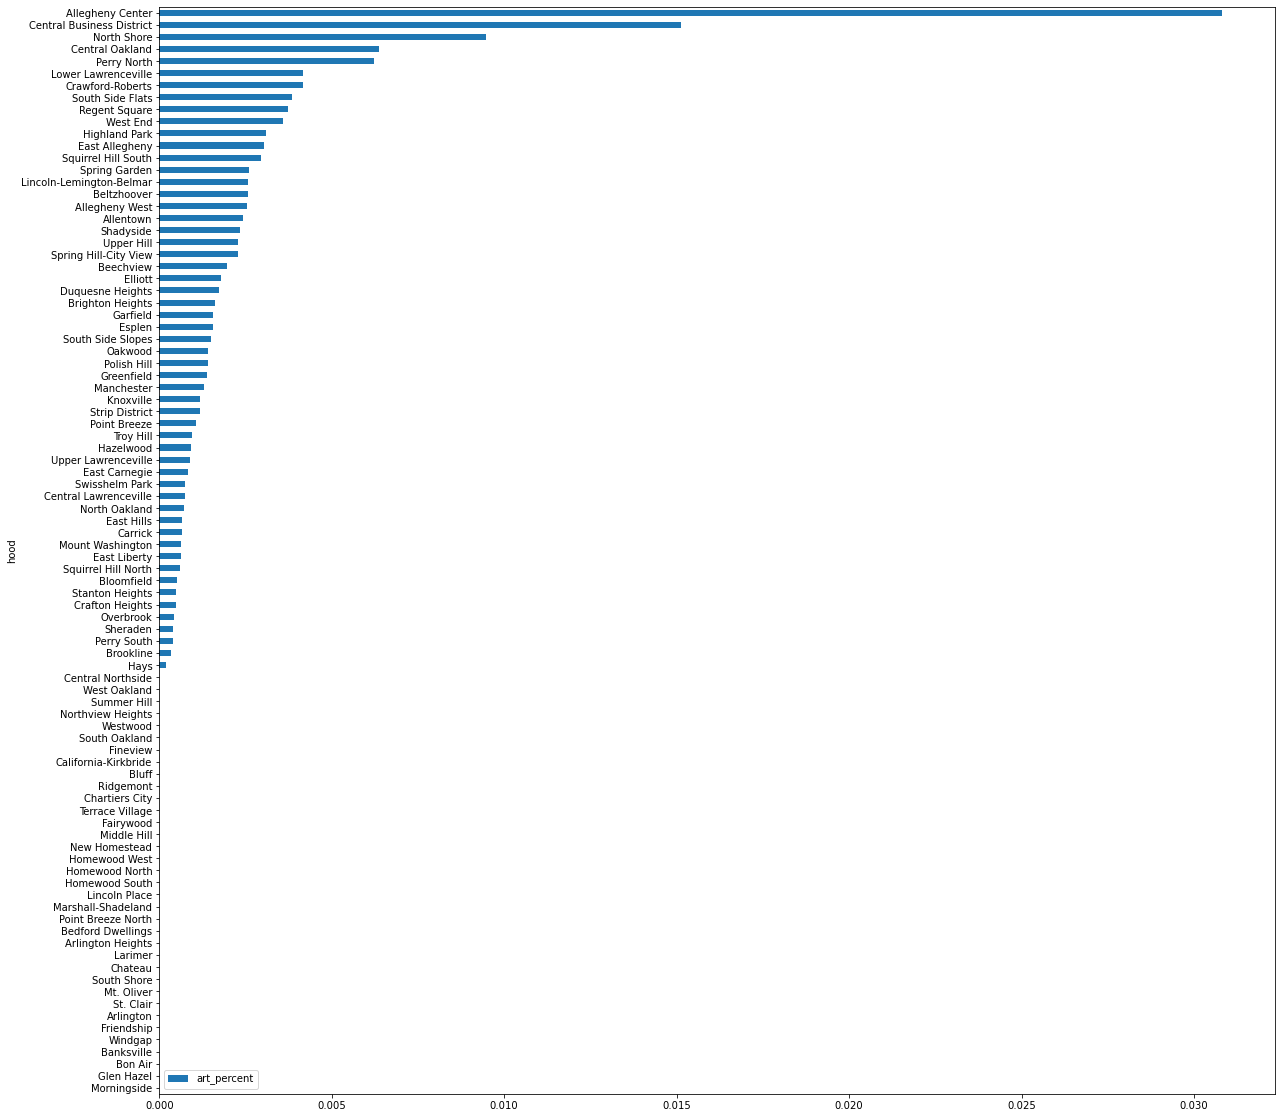

In [39]:
area_sort = area_map.sort_values(by=['art_percent'], ascending=True)
area_sort_graph = area_sort.plot.barh(x='hood', y='art_percent', figsize=(20, 20))
area_sort_graph

Based on our data, we get the conclusion that Allegheny Center has the most access to public art. 

## Conclusions

We obtain the overall best neighborhood by finding the average rank of neighborhoods present in all three of our final dataframes. 

In [40]:
# Minhal's final dataframe
df4 = df4.sort_values('rec_ratio',ascending=False).reset_index(drop=True)
df4['rec_rank'] = df4.index + 1
df4 = df4.rename(columns={'Neighborhood':'hood'})

# Zhen's final dataframe
area_sort = area_sort.sort_values('art_percent',ascending=False).reset_index(drop=True)
area_sort['art_rank'] = area_sort.index + 1

# Keyon's final dataframe
merged_final_sort = merged_final_sort.sort_values('clean_score',ascending=False).reset_index(drop=True)
merged_final_sort['clean_rank'] = merged_final_sort.index + 1

We 'rank' each dataframe by sorting their values in descending order, then adding a column of sequential numbers.

In [41]:
# Creating final 
final_list = area_sort[['hood','art_rank']].merge(merged_final_sort[['hood','clean_rank']], on='hood')
final_list = final_list.merge(df4[['hood','rec_rank']], on='hood')

final_list['average_rank'] = (final_list['art_rank'] + final_list['rec_rank'] + final_list['clean_rank'])/3
final_list.average_rank = final_list.average_rank.astype(int)

display(final_list.sort_values('average_rank',ascending=True).reset_index(drop=True))

,hood,art_rank,clean_rank,rec_rank,average_rank
0,Squirrel Hill South,13,8,2,7
1,South Side Flats,8,6,10,8
2,Shadyside,19,1,11,10
3,Highland Park,11,35,1,15
4,Brighton Heights,25,23,7,18
5,Point Breeze,35,21,6,20
6,Bloomfield,48,4,14,22
7,Greenfield,31,26,13,23
8,Mount Washington,45,20,5,23
9,South Side Slopes,28,41,3,24


Finally, by merging all of our edited dataframes, we create one last dataframe with a column where each value is the average of the neighborhood's rankings.

From this, it can be seen that based on our metrics, **Squirrel Hill South** is the best neighborhood in Pittsburgh!

## Reflections
**Keyon**: According to my data Shadyside is both a clean neighborhood, with lots of local love. In other words, it is a clean, and close-knit community. However, this is only taking into account community and cleanliness. However, the top 10 in this list, are magnitudes better than the rest of the 69 neighborhoods. At number 8, Squirrel Hill becomes a clear winner when you take into account multiple factors judging the Best Neighborhood.

**Minhal**: Because I'm currently studying remotely, I unfortunately haven't had the chance to explore Pittsburgh's neighborhoods. I have heard good things about Squirrel Hill South though, so it seems our answer is on the right track! Even though it falls just outside of the top 10 in terms of art, taking other factors into consideration like community, neatness, and R&R tells that us it is indeed one of Pittsburgh's best neighborhoods.

**Zhen**: After doing this project, I get a better understanding of Pittsburgh neighborhoods. I haven't explored those neighborhoods much. By averaging the rankings in all three of our metrics, Squirrel Hill South is the winner. (I hope to visit it someday!) By exploring the dataset of public art that I used, I also know how public art makes the community more vibrant and improves the social environment.